## Classificação

In [20]:
# ! python3 -m pip install imblearn
# ! python3 -m pip install delayed

In [21]:
import numpy
import pandas
import warnings
import joblib


from matplotlib import pyplot
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.feature_extraction.text import TfidfVectorizer
from operator import itemgetter
from wordcloud import WordCloud


In [22]:
pandas.set_option('display.max_columns', None)
pandas.set_option('display.max_rows', None)
pandas.set_option('display.max_colwidth', -1)

<ipython-input-22-69b7d73196e0>:3: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pandas.set_option('display.max_colwidth', -1)


In [23]:
refined = f'../Datalake/Refined'
real_data = pandas.read_csv(f'{refined}/review_store.csv')
data = pandas.read_csv(f'{refined}/data_labeled_refined.csv')

In [24]:
data = data[~data['category'].isin(['ignorar'])]

In [25]:
data.head(1)

,date,version,author,rating,review,os,review_cleaned,review_stop_word,review_tokenized,review_stemming,review_lematized,category,cluster
0,2018-11-10 14:34:19,7.0.7,Gustavo Rocha,1,"pessimo, nao tem produtos e nao funciona nafa",android,pessimo nao tem produtos e nao funciona nafa,pessimo nao produtos nao funciona nafa,"['pessimo', 'nao', 'produtos', 'nao', 'funciona', 'nafa']","['pessim', 'nao', 'produt', 'nao', 'funcion', 'naf']","['pessimo', 'nao', 'produtos', 'nao', 'funciona', 'nafa']",nao funciona,4


## Modelo TFIDf

In [26]:
documents = data['review_lematized'].astype('str').values


vectorizer = TfidfVectorizer(ngram_range=(1, 3),max_features=1500,min_df=5, max_df=0.8).fit(documents)
vectorizer

TfidfVectorizer(max_df=0.8, max_features=1500, min_df=5, ngram_range=(1, 3))

In [27]:
vectorizer.transform(documents)

<670x404 sparse matrix of type '<class 'numpy.float64'>'
	with 6243 stored elements in Compressed Sparse Row format>

In [28]:
joblib.dump(vectorizer, 'vectorizer.joblib')

['vectorizer.joblib']

## Modelo de regressão logística

In [29]:
X = vectorizer.transform(documents)
y = data.category.values

oversample = RandomOverSampler(random_state=42)
X_over, y_over = oversample.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, test_size=0.3, random_state=42)

In [30]:
classifier = LogisticRegression(
    multi_class='ovr',
    solver='lbfgs',
    class_weight='balanced',
    random_state=42
).fit(X_train, y_train)

classifier

LogisticRegression(class_weight='balanced', multi_class='ovr', random_state=42)

In [31]:
joblib.dump(classifier, 'classifier.joblib')

['classifier.joblib']

In [32]:
y_pred = classifier.predict(X_test)
print(classification_report(y_test, y_pred))

                    precision    recall  f1-score   support

        aplicativo       0.84      0.86      0.85        37
     avaliacao boa       1.00      0.97      0.98        33
    avaliacao ruim       0.96      0.90      0.93        29
           cerveja       1.00      0.97      0.98        30
           entreda       1.00      1.00      1.00        33
           entrega       0.70      0.92      0.80        36
      entregadores       1.00      0.97      0.99        39
       nao consigo       1.00      1.00      1.00        28
      nao funciona       1.00      1.00      1.00        27
opcoes de produtos       1.00      0.74      0.85        34
   problema pedido       0.94      1.00      0.97        34

          accuracy                           0.94       360
         macro avg       0.95      0.94      0.94       360
      weighted avg       0.95      0.94      0.94       360



## Bigrama e Trigrama

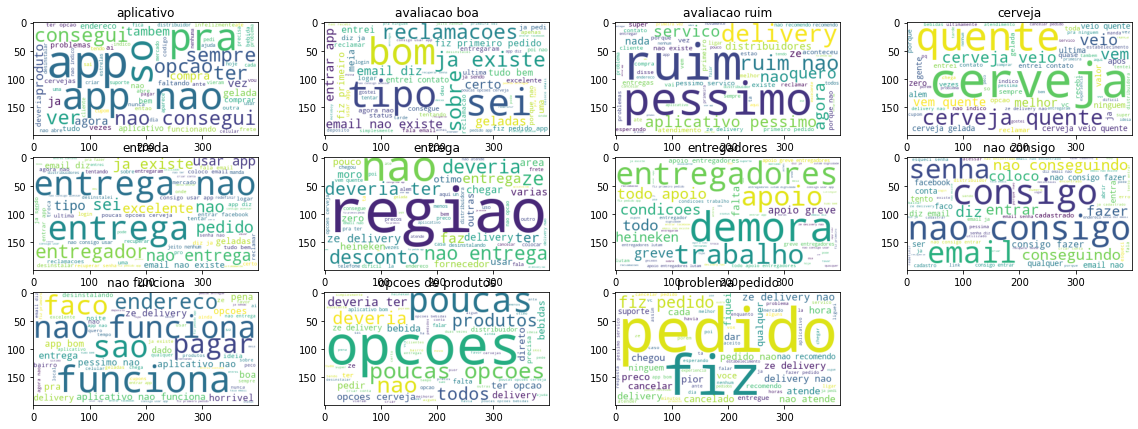

In [33]:
mw = 70
fig = pyplot.figure(figsize = (20, 12))

for i, v in enumerate(classifier.classes_):
    coefficients = classifier.coef_[i]
    keys = coefficients.argsort()[::-1][:mw]
    idx_to_word = {v: k for k, v in vectorizer.vocabulary_.items()}
    words = list(itemgetter(*keys)(idx_to_word))
    dictionary = {}
    d = 300
    for w in words:
        dictionary[w] = d
        d = d - 3

    wc = WordCloud(background_color='white', max_words=mw, relative_scaling=0.1, normalize_plurals=True)
    image = wc.generate_from_frequencies(dictionary)

    ax = fig.add_subplot(5, 4, (i + 1))
    pyplot.imshow(image)
    ax.set_title(v)

## Resultado com base real

<AxesSubplot:ylabel='label'>

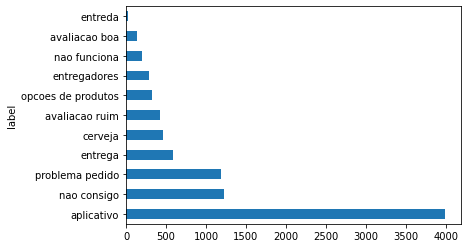

In [34]:
real_data['label'] = classifier.predict(vectorizer.transform(real_data.review_lematized.values))
real_data.groupby(['label'])['author'].count().sort_values(ascending=False).plot.barh()

In [35]:
real_data.label.unique()

array(['entrega', 'aplicativo', 'problema pedido', 'nao funciona',
       'avaliacao ruim', 'nao consigo', 'opcoes de produtos',
       'entregadores', 'avaliacao boa', 'cerveja', 'entreda'],
      dtype=object)

In [36]:
real_data.to_csv(f'{refined}/review_store_classified.csv', sep=',', encoding='utf-8', index=False)